In [13]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, text, union, union_all, literal

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = 'cdd1395a-e46d-4b8a-984a-eeb772e91ec4'
IMPORT_ID = '2e421d0a-f2ee-449a-b425-a71b10934b98'
SCHEME_ID = '4b355eb2-39c6-4517-a0d2-c260502392b3'

In [2]:
df = pd.read_feather('../../data/scs/predictions.arrow')
df_orig = pd.read_feather('../../data/scs/predictions_orig.arrow')

In [3]:
df.head()

id                                       display_name  \
0  W997892983  Non-market value evaluation on integrated exte...   
1  W992395523  Effects of straw, phenol and organic acids on ...   
2  W985683334  Soil Carbon Sequestration in Mexico and Centra...   
3  W984747004         Soil Carbon Sequestration in Latin America   
4  W982997543  Monitoring spatio-temporal changes of soil car...   

                                               title  \
0  Non-market value evaluation on integrated exte...   
1  Effects of straw, phenol and organic acids on ...   
2  Soil Carbon Sequestration in Mexico and Centra...   
3         Soil Carbon Sequestration in Latin America   
4  Monitoring spatio-temporal changes of soil car...   

                                            abstract  \
0  Externality is a ubiquitous economic phenomeno...   
1  This study examined the change of soil carbon ...   
2                                               None   
3  It is widely recognized that soil carbon (C) s...   
4  Legacy soil data is an important data source f...   

                                      title_abstract  \
0  Non-market value evaluation on integrated exte...   
1  Effects of straw, phenol and organic acids on ...   
2  Soil Carbon Sequestration in Mexico and Centra...   
3  Soil Carbon Sequestration in Latin America It ...   
4  Monitoring spatio-temporal changes of soil car...   

                                         authorships  \
0  [{'author': {'display_name': 'Qiong Ma', 'id':...   
1  [{'author': {'display_name': 'Hongling Ma', 'i...   
2  [{'author': {'display_name': 'Jorge D. Etcheve...   
3  [{'author': {'display_name': 'Rattan Lal', 'id...   
4  [{'author': {'display_name': 'Yiyi Sulaeman', ...   

                                              biblio  \
0  {"volume":"25","issue":"2","first_page":"154",...   
1  {"volume":"22","issue":"1","first_page":"71","...   
2                                               None   
3                                               None   
4                                               None   

                                           locations  is_retracted  \
0  [{'is_oa': False, 'is_primary': True, 'landing...         False   
1  [{'is_oa': False, 'is_primary': True, 'landing...         False   
2  [{'is_oa': False, 'is_primary': True, 'landing...         False   
3  [{'is_oa': False, 'is_primary': True, 'landing...         False   
4  [{'is_oa': False, 'is_primary': False, 'landin...         False   

  is_accepted  cited_by_count  is_paratext is_published language  \
0       False               0        False        False       en   
1       False               0        False        False       en   
2       False               3        False        False       en   
3       False               9        False        False       en   
4       False               0        False        False       en   

           type        mag  publication_year            _version_  \
0       article  997892983              2013  1792777992841199624   
1       article  992395523              2009  1792712295818723334   
2  book-chapter  985683334              2006  1792854775877861378   
3  book-chapter  984747004              2006  1792725330928074756   
4       article  982997543              2010  1792884046839152640   

       publication_date          created_date              updated_date  \
0  2013-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-21T04:41:57.827Z   
1  2009-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-06T14:42:33.158Z   
2  2006-07-05T00:00:00Z  2016-06-24T00:00:00Z  2024-02-24T03:12:00.112Z   
3  2006-07-05T00:00:00Z  2016-06-24T00:00:00Z  2024-02-18T05:54:54.959Z   
4  2010-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-24T08:42:34.233Z   

   indexed_in                                       doi  pmid pmcid  \
0        None                                      None  None  None   
1        None                                      None  None  None   
2  [cros

In [4]:
with db_engine.session() as session:
    stmt_a = (
        select(AcademicItem.item_id, AcademicItem.openalex_id, literal(0).label('src'))
        .where(AcademicItem.openalex_id.in_(set(df['id'])), 
               AcademicItem.project_id == PROJECT_ID)
    )
    stmt_b = (
        select(AcademicItemVariant.item_id, AcademicItemVariant.openalex_id, literal(1).label('src'))
        .join(Item, and_(AcademicItemVariant.item_id == Item.item_id,
                         Item.project_id == PROJECT_ID))
        .where(AcademicItemVariant.openalex_id.in_(set(df['id'])))
    )
    # print(union(stmt_a, stmt_b))
    rslt = session.execute(union_all(stmt_a, stmt_b)).mappings().all()

    irslt = session.execute(select(m2m_import_item_table).where(m2m_import_item_table.c.import_id==IMPORT_ID)).mappings().all()
    item_ids = [str(r['item_id']) for r in irslt]

    erslt = session.execute(
        select(AcademicItem.item_id, AcademicItem.openalex_id)
        .where(AcademicItem.project_id == PROJECT_ID, AcademicItem.text == None)
    ).mappings().all()
    empty_item_ids = set([str(e['item_id']) for e in erslt])
    empty_openalex_ids = set([str(e['openalex_id']) for e in erslt])

rdf = pd.DataFrame(rslt)
mapping = {
    str(r['openalex_id']): str(r['item_id'])
    for _, r in rdf.iterrows()
}
imp_mapping = {
    k: v
    for k, v in mapping.items()
    if v in set(item_ids)
}

print('Number of items in df:', len(df))
print('Number of results:', len(rslt))
print(f'Number of items in project with missing abstract: {len(erslt):,} (unique item_ids: {len(empty_item_ids):,} / openalex_ids: {len(empty_openalex_ids):,})')
print(f'Size of mapping: {len(mapping):,} (keys) -> {len(set(mapping.values())):,} (values)')
print(f'Size of import mapping: {len(imp_mapping):,} (keys) -> {len(set(imp_mapping.values())):,} (values)')
print('Number of unique item_ids:', len(set(rdf['item_id'])))
print('Number of unique OA ids in result:', len(set(rdf['openalex_id'])))
print('Number of unique OA ids in result (0):', len(set(rdf[rdf['src']==0]['openalex_id'])))
print('Number of unique OA ids in result (1):', len(set(rdf[rdf['src']==1]['openalex_id'])))
print('Number of unique OA ids in df:',len(set(df['id'])))
print(f'Number of items in import: {len(irslt):,} (and unique item_ids: {len(set(item_ids)):,})')
print(f'Number of items in import without matching mapping: {len(set(item_ids) - set(mapping.values())):,}')
print(f'Number of items in import without matching import mapping: {len(set(item_ids) - set(imp_mapping.values())):,}')

Number of items in df: 5423
Number of results: 10569
Number of items in project with missing abstract: 669 (unique item_ids: 669 / openalex_ids: 665)
Size of mapping: 5,423 (keys) -> 5,122 (values)
Size of import mapping: 5,401 (keys) -> 5,105 (values)
Number of unique item_ids: 5180
Number of unique OA ids in result: 5423
Number of unique OA ids in result (0): 5123
Number of unique OA ids in result (1): 5311
Number of unique OA ids in df: 5423
Number of items in import: 5,115 (and unique item_ids: 5,115)
Number of items in import without matching mapping: 10
Number of items in import without matching import mapping: 10


Review score is >=0.5: 1084
Review is most confident method of all: 1202


<Axes: >

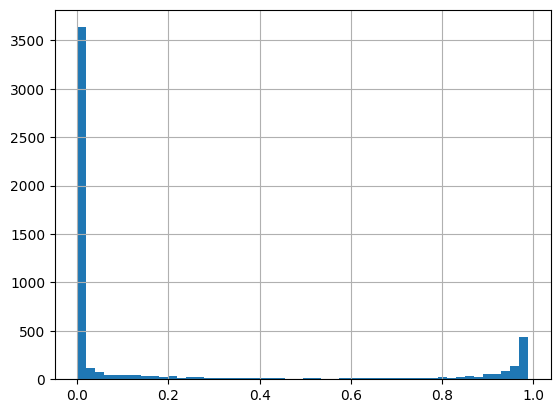

In [5]:
keys = ['meth|0', 'meth|1', 'meth|2', 'meth|3', 'meth|4', 'meth|5', 'meth|6', 'meth|7', 'meth|8', 'meth|9']
print('Review score is >=0.5:', (df['meth|5']>=0.5).sum())
print('Review is most confident method of all:', (df[keys].to_numpy().argmax(axis=1)==5).sum())
df['meth|5'].hist(bins=50)

In [6]:
mask_reviews = df[keys].to_numpy().argmax(axis=1) == 5
mask_import = df['id'].isin(imp_mapping.keys())
mask_abs = ~df['id'].isin(empty_openalex_ids)
mask = mask_reviews & mask_import & mask_abs
print(mask_import.sum(), mask_abs.sum(), mask_reviews.sum(), mask.sum())

5401 4944 1202 1141


In [7]:
a = [imp_mapping[i] for i in df[mask]['id']]
print(len(a), len(set(a)))

1141 1112


In [9]:
sample = df[mask].sample(n=20)
sample

id                                       display_name  \
2672  W2993144361  Soil Organic Carbondistribution, Mitigation an...   
2390  W3049634961  The role of zero-tillage in climate change mit...   
3360  W2714313730  Biotic interactions and trait-based ecosystem ...   
4777  W2047132925  Impacts of land management on fluxes of trace ...   
2201  W3121469118  The non-permanence of optimal soil carbon sequ...   
217   W4389443336  Conservation Agriculture for Soil Health and C...   
3259  W2768755644  Australian aboriginal land management: Constra...   
2374  W3081627330  Minimal soil disturbance and increased residue...   
1116  W4290617552  Optimized utilization of <i>Salix</i>—Perspect...   
2359  W3083108108  Demonstrating sustainable land management and ...   
370   W4386834868  A Review on In-Situ Denitrification Technology...   
5288  W1557490420  Agriculture and climate change: An agenda for ...   
4949  W2011382982  Managing woody bamboos for carbon farming and ...   
1590  W4206177509  Soil carbon sequestration – An interplay betwe...   
2948  W2913814116  Assessing the terrestrial capacity for Negativ...   
5347  W1499912085  Harnessing Farms and Forests in the Low-Carbon...   
3148  W2797870019  Conservation Agriculture Effects on Soil Green...   
3855  W2373484329  Effect of Agricultural Practices on Soil Organ...   
3982  W2341851380      PERANAN PENTING PENGELOLAAN PENYERAPAN KARBON   
1134  W4288040104  Surface Modification of Biochar for Dye Remova...   

                                                  title  \
2672  Soil Organic Carbondistribution, Mitigation an...   
2390  The role of zero-tillage in climate change mit...   
3360  Biotic interactions and trait-based ecosystem ...   
4777  Impacts of land management on fluxes of trace ...   
2201  The non-permanence of optimal soil carbon sequ...   
217   Conservation Agriculture for Soil Health and C...   
3259  Australian aboriginal land management: Constra...   
2374  Minimal soil disturbance and increased residue...   
1116  Optimized utilization of <i>Salix</i>—Perspect...   
2359  Demonstrating sustainable land management and ...   
370   A Review on In-Situ Denitrification Technology...   
5288  Agriculture and climate change: An agenda for ...   
4949  Managing woody bamboos for carbon farming and ...   
1590  Soil carbon sequestration – An interplay betwe...   
2948  Assessing the terrestrial capacity for Negativ...   
5347  Harnessing Farms and Forests in the Low-Carbon...   
3148  Conservation Agriculture Effects on Soil Green...   
3855  Effect of Agricultural Practices on Soil Organ...   
3982      PERANAN PENTING PENGELOLAAN PENYERAPAN KARBON   
1134  Surface Modification of Biochar for Dye Remova...   

                                               abstract  \
2672  The 17 Sustainable Development Goals (SDGs) of...   
2390  An estimated 11% of the world’s land surface i...   
3360  Recent emphasis on ecosystem services as a fra...   
4777  Abstract. Land use change and land management ...   
2201  Carbon sequestration in agricultural soils is ...   
217   Mountains the most significant agroecosystems ...   
3259  For many years, natural resource legislation i...   
2374  The conservation treatments were found to sign...   
1116  Abstract Bioenergy will be one of the most imp...   
2359  &amp;lt;p&amp;gt;Globally, grazing systems hav...   
370   The groundwater nitrate levels in the Jaffna p...   
5288  Table of Contents: •Overview by Gerald C. Nels...   
4949  Research on identifying cost-effective managed...   
1590  Soil carbon sequestration (SCS) refers to the ...   
2948  Negative emissions technologies (NETs) and the...   
5347  Foreword vii Preface ix Part I. Overview 1. In...   
3148  Conservation Agriculture (CA) alters soil prop...   
3855  Soil carbon sequestration of terrestrial ecosy...   
3982  This paper represents a review of managing car...   
1134  Nowadays, biochar is being studied to a great ...   

                      

In [14]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = False

name = '20240709_testing_all'
description = '20 random documents assigned to all (conditions predicted as review, has abstract, in import "openalex snapshot 2024-06-17")'

users = [
    ('d614015f-666c-46fb-ae63-971099457469', 'sylvia.vetter'),
    ('82b977c9-5a30-4aa5-9480-955f8ee5a0de', 'jon.mccalmont'),
    ('746416ce-6229-44f9-b177-b0ca95b2d740', 'matthias.kuhnert'),
    ('0ce32bb9-3b2c-41c5-abc0-636ab1e29220', 'rebecca.hellfeld'),
    ('fd1306fd-13e1-46e4-b931-91e587b0a806', 'marta.dondini'),
    ('047f4dfb-791e-4e7d-8533-a5b160628195', 'david.knight'),
    ('48668e55-88c9-4411-a705-b5bf955515b2', 'mohamed.abdalla'),
    ('d04b5c8a-2bed-4982-b7f7-d92790f3d9c3', 'anita.shepherd'),
    ('4f91d69e-b940-4131-b7fa-33de3a0fa036', 'david.mcbey'),
    ('71e85c0c-69ce-46c6-b35e-c11a6f9a7fa3', 'alexander.popp'),
    ('e10e59f3-a9dc-4528-8f20-535fdf99d699', 'pete.smith'),
    ('566b48db-0f7a-467d-a96a-0366b05b5d64', 'grant.campbell'),
    ('4213dbc3-8787-407a-b899-07611acbe1f9', 'astley.hastings'),
    # ('fd641232-bada-466e-9a3b-fb12038f5508', 'tim.repke'),
    ('180f19f0-b418-40b3-a8eb-586c2de151f7', 'licida.giuliani'),
    ('4b52830e-1fd4-4d46-9c4e-253abf63ae4a', 'jennifer.wardle'),
    ('461dfdca-21bf-4de9-89fb-b4bd5e07c61a', 'kristine.karstens'),
]

with db_engine.session() as session:
    scope_id = str(uuid.uuid4())
    print(f'Creating scope with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=name,
            description=description
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, oa_id in enumerate(sample['id']):
        item_id = imp_mapping[oa_id]
        print(f'#{di + 1}/{len(sample)} | Creating assignments for {oa_id} -> {item_id}')
        for user_id, username in users:
            assi_id = uuid.uuid4()

            if not DRY_RUN:
                assi = Assignment(assignment_id=assi_id,
                                  assignment_scope_id=scope_id,
                                  user_id=user_id,
                                  item_id=item_id,
                                  annotation_scheme_id=SCHEME_ID,
                                  status=AssignmentStatus.OPEN,
                                  order=di)
                session.add(assi)
                session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')
    print(f'Created {cnt} assignments!')
    

Creating scope with ID 38d014f3-90e0-4c0c-9462-dbef1ec96784
#1/20 | Creating assignments for W2993144361 -> 217a7056-809c-4e9c-a8f4-7e09ed58b87b
  -> sylvia.vetter via ba1e2d5f-7f3b-4ae6-98ac-04cadb65167c for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> jon.mccalmont via e080f593-87a3-4350-915b-8b6abee94ae9 for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> matthias.kuhnert via e7ceb443-1691-4aa0-a63f-bd7e8af501a3 for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> rebecca.hellfeld via a05fcff8-7c78-49bc-ab04-0718533442f0 for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> marta.dondini via e5b4d5dc-32a0-44d3-87fb-24b2c34fe2bf for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> david.knight via 7d26b768-a858-4ee8-9091-40d5f2d9121e for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> mohamed.abdalla via 7b3dae9c-eac5-4ba2-aab9-905211e9d399 for scope 38d014f3-90e0-4c0c-9462-dbef1ec96784
  -> anita.shepherd via 2da665e2-815a-4635-934c-e383392fcdcf for scope 38d014f3-90e0-4c0c-9462-dbef

In [101]:
with db_engine.session() as session:
    r = session.execute(text('''
    SELECT u.user_id, u.username
    FROM project_permissions pm
    JOIN "user" u ON pm.user_id=u.user_id
    WHERE pm.project_id = 'cdd1395a-e46d-4b8a-984a-eeb772e91ec4'
    ''')).mappings().all()
    for ri in r:
        print(f"('{ri['user_id']}', '{ri['username']}'),")

('d614015f-666c-46fb-ae63-971099457469', 'sylvia.vetter'),
('82b977c9-5a30-4aa5-9480-955f8ee5a0de', 'jon.mccalmont'),
('746416ce-6229-44f9-b177-b0ca95b2d740', 'matthias.kuhnert'),
('0ce32bb9-3b2c-41c5-abc0-636ab1e29220', 'rebecca.hellfeld'),
('fd1306fd-13e1-46e4-b931-91e587b0a806', 'marta.dondini'),
('047f4dfb-791e-4e7d-8533-a5b160628195', 'david.knight'),
('48668e55-88c9-4411-a705-b5bf955515b2', 'mohamed.abdalla'),
('d04b5c8a-2bed-4982-b7f7-d92790f3d9c3', 'anita.shepherd'),
('4f91d69e-b940-4131-b7fa-33de3a0fa036', 'david.mcbey'),
('71e85c0c-69ce-46c6-b35e-c11a6f9a7fa3', 'alexander.popp'),
('e10e59f3-a9dc-4528-8f20-535fdf99d699', 'pete.smith'),
('566b48db-0f7a-467d-a96a-0366b05b5d64', 'grant.campbell'),
('4213dbc3-8787-407a-b899-07611acbe1f9', 'astley.hastings'),
('fd641232-bada-466e-9a3b-fb12038f5508', 'tim.repke'),
('180f19f0-b418-40b3-a8eb-586c2de151f7', 'licida.giuliani'),
('4b52830e-1fd4-4d46-9c4e-253abf63ae4a', 'jennifer.wardle'),
('461dfdca-21bf-4de9-89fb-b4bd5e07c61a', 'kristin

In [ ]:
FR